### Klasy bazowe

In [1]:
import abc

import tensorflow as tf

import tensorflow_addons as tfa

import numpy as np

from sklearn.metrics import f1_score

import time

class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer."""
        pass


class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def fit(self, **kwargs):
        """Fits the model.

        Replaces original fit method.
        
        More information can be found in documentation:
        https://www.tensorflow.org/guide/eager
        https://www.tensorflow.org/guide/autodiff
        """
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts x"""
        pass

### Instrukcje pomoniczne do wykonania przetwarzania wstępnego


In [2]:
import pickle

# Wczytanie zbioru danych
dataset_path = 'dataset.pkl'

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)

def load_x_y(ds_type):
    images = dataset[ds_type]['X']
    labels = dataset[ds_type]['y']
    return images, labels

# Ustawienie ziarna
tf.random.set_seed(1234)
def data_preprocessing(images, labels):
    # Zmiana rozmiaru obrazu z 224x224 do 64x64
    images = tf.image.resize(
        images, [64, 64], 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
        preserve_aspect_ratio=False,
        name=None
    )
    # Spłaszczenie obrazu do jednego wymiaru (np. z 64x64x3 do 12288)
    images = tf.reshape(images, [images.shape[0],-1])
    # Zmiana typu obrazów z int na float i normalizacja wartości pikseli z przedziału 0-255 do przedziału 0-1
    images = tf.cast(images, tf.float32) / 255.0
    # Zmiana wymiarowości z [8870] na [8870, 1] w celu zastosowania `SparseCategoricalCrossentropy`
    labels = tf.reshape(labels, [-1, 1])
    
    return images, labels

# Do iterowania zbioru danych i podzielenia na paczki (ang. batch) można wykorzystać interfejs zdefiniowany w `tensorflow.data.Dataset`
def create_ds(images, labels, batch_size = 100):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels)) 
    dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size=batch_size)
    return dataset



In [3]:
images_train, labels_train = load_x_y('train')
images_train, labels_train = data_preprocessing(images_train, labels_train)
train_ds = create_ds(images_train, labels_train)

images_test_before, labels_test = load_x_y('test')
images_test, labels_test = data_preprocessing(images_test_before, labels_test)
test_ds = create_ds(images_test, labels_test)

images_val, labels_val = load_x_y('validation')
images_val, labels_val = data_preprocessing(images_val, labels_val)
val_ds = create_ds(images_val, labels_val)



### Rozwiązanie

In [4]:
class BaseLayer(AbstractLayer):

    def __init__(self, activation_function, input_dim, units, initializer_w, initializer_b):
        super(BaseLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer=initializer_w)
        self.b = self.add_weight(shape=(units,), initializer=initializer_b)
        self.activation_function = activation_function
        self.units = units
        
    def call(self, inputs):
        return self.activation_function(tf.matmul(inputs, self.w) + self.b)

class BaseModel(AbstractModel):
    
    def __init__(self,initializer_w, initializer_b): 
        super(AbstractModel, self).__init__()
        self.l_1 = BaseLayer(activation_function = tf.keras.activations.relu, 
                             input_dim = 12288, units = 256, initializer_w = initializer_w, initializer_b = initializer_b)
        self.l_2 = BaseLayer(activation_function = tf.keras.activations.softmax, 
                             input_dim = 256, units = 14, initializer_w = initializer_w, initializer_b = initializer_b)

    def call(self, inputs, training=False):
        inputs_2 = self.l_1(inputs)
        return self.l_2(inputs_2)
        

    def fit(self, **kwargs):
        self.epoch_loss_train = []
        self.epoch_f1_train = []
        self.epoch_loss_val = []
        self.epoch_f1_val = []
        self.epoch_accuracy = []
        train_ds = kwargs.get("train_ds", None)
        batch_size = kwargs.get("batch_size", 100)
        lr = kwargs.get("lr", 0.001)
        epoch_num = kwargs.get("epoch_num", 25)
        optimizer = kwargs.get("optimizer", tf.keras.optimizers.Adam)
        optimizer = optimizer(learning_rate=lr)
        cost_func = kwargs.get("cost_func", tf.keras.losses.SparseCategoricalCrossentropy())
        #val_ds = kwargs.get("val_ds", None)
        time_total_start = time.time()
        for epoch in range(epoch_num):
            time_epoch_start = time.time()
            epoch_acc = tf.keras.metrics.SparseCategoricalAccuracy()
            #print("\nStart of epoch %d" % (epoch,))
            f1_train = tfa.metrics.F1Score(num_classes=14, average="macro")
            f1_val = tfa.metrics.F1Score(num_classes=14, average="macro")
            #TRAIN
            for x, y in train_ds:
                with tf.GradientTape() as tape:
                    logits = self.call(x)
                    loss = cost_func(y, logits)
                grads = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                f1_train.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                   tf.one_hot(tf.argmax(logits, axis=-1), 
                                    depth=14))
                epoch_acc.update_state(y, logits)
            self.epoch_loss_train.append(loss)
            self.epoch_f1_train.append(f1_train.result())
            self.epoch_accuracy.append(epoch_acc.result().numpy())
            time_epoch_end = time.time()
            time_epoch = time_epoch_end - time_epoch_start
            print("Time epoch: ", time_epoch)
        time_total_end = time.time() 
        time_total = time_total_end - time_total_start
        print("Time total: ", time_total)
            #print(": Loss ={:.3f}, F1 ={:.3f}".format(self.epoch_loss_train[-1],self.epoch_f1_train[-1]))
    

    def predict(self, x):
        logits = self.call(x)
        return logits

In [5]:
class NewModel(BaseModel):
    def __init__(self,initializer_w, initializer_b): 
        super(AbstractModel, self).__init__()
        self.l_1 = BaseLayer(activation_function = tf.keras.activations.relu, 
                             input_dim = 12288, units = 256, initializer_w = initializer_w, initializer_b = initializer_b)
        self.l_2 = BaseLayer(activation_function = tf.keras.activations.relu, 
                             input_dim = 256, units = 256, initializer_w = initializer_w, initializer_b = initializer_b)
        self.l_3 = BaseLayer(activation_function = tf.keras.activations.softmax, 
                             input_dim = 256, units = 14, initializer_w = initializer_w, initializer_b = initializer_b)

    def call(self, inputs, training=False):
        inputs_2 = self.l_1(inputs)
        inputs_3 = self.l_2(inputs_2)
        return self.l_3(inputs_3)

### Zadanie 1

In [6]:
def run_experiments(initializer_w, initializer_b, layer_num):
    if layer_num == 2:
        model = BaseModel(initializer_w = initializer_w, initializer_b = initializer_b)
    else:
        model = NewModel(initializer_w = initializer_w, initializer_b = initializer_b)
    model.fit(train_ds = train_ds)
    y_pred = model.predict(images_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = labels_test
    f1 = f1_score(y_true, y_pred, average='micro')
    print("PARAMS: ", initializer_w, initializer_b,layer_num)
    print("LOSS: {:.3f}".format(model.epoch_loss_train[-1]))
    print("F1:", f1)

In [11]:
run_experiments("random_uniform", "random_uniform", 2)
run_experiments("random_uniform", "random_normal", 2)
run_experiments("random_normal", "random_uniform", 2)
run_experiments("random_normal", "random_normal", 2)

run_experiments("random_uniform", "random_uniform", 3)
run_experiments("random_uniform", "random_normal", 3)
run_experiments("random_normal", "random_uniform", 3)
run_experiments("random_normal", "random_normal", 3)

Time epoch:  3.6928932666778564
Time epoch:  3.6659064292907715
Time epoch:  3.7328686714172363
Time epoch:  3.649914264678955
Time epoch:  3.712881088256836
Time epoch:  3.663909673690796
Time epoch:  3.665903329849243
Time epoch:  3.698888063430786
Time epoch:  3.9127678871154785
Time epoch:  4.234580039978027
Time epoch:  4.218591690063477
Time epoch:  3.702885389328003
Time epoch:  3.986724615097046
Time epoch:  3.6798951625823975
Time epoch:  3.976731777191162
Time epoch:  3.7818386554718018
Time epoch:  3.880783796310425
Time epoch:  3.661909580230713
Time epoch:  3.664907932281494
Time epoch:  3.7028861045837402
Time epoch:  3.742859125137329
Time epoch:  3.701887369155884
Time epoch:  3.6938905715942383
Time epoch:  3.5939486026763916
Time epoch:  3.802828788757324
Time total:  94.43407368659973
PARAMS:  random_uniform random_uniform 2
LOSS: 1.438
F1: 0.22454484153742413
Time epoch:  3.6918909549713135
Time epoch:  3.672900676727295
Time epoch:  3.662909984588623
Time epoch:  3

### Wyniki 1

Eksperyment 1A został przeprowadzony przy wykorzystaniu funkcji random normal i random uniform.
Eksperyment 1B został przeprowadzony na sieci 2 i 3 warstwowej.

Najlepszy wynik został osiągnięty dla następującej konfiguracji parametrów: 
- LOSS : random_uniform - random_uniform - 2 Wyniki: LOSS = 1.438, F1 = 0.22454484153742413
- F1: random_normal - random_normal - 3 Wyniki: LOSS = 1.521, F1 = 0.26365475387727577

Do dalszych eksperymentów zostanie wykorzystana konfiguracja parametrów: random_normal - random_normal - 3

### Zadanie 2

In [15]:
def run_experiments_hiperparams(initializer_w, initializer_b, layer_num, epoch, lr, optimizer, batch_size):
    model = NewModel(initializer_w = initializer_w, initializer_b = initializer_b)
    train_ds = create_ds(images_train, labels_train, batch_size)
    test_ds = create_ds(images_test, labels_test, batch_size)
    model.fit(train_ds = train_ds, epoch_num = epoch, lr = lr, optimizer = optimizer, batch_size = batch_size)
    y_pred = model.predict(images_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = labels_test
    f1 = f1_score(y_true, y_pred, average='micro')
    print("PARAMS: ", epoch, lr, optimizer, batch_size)
    print("LOSS: {:.3f}".format(model.epoch_loss_train[-1]))
    print("F1:", f1)

In [16]:
#Experiments params
epoch_num = [30, 50]
lr_values = [0.0001, 0.005, 0.01]
optimizer = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]
batch_size = [100, 500]

In [17]:
for epoch in epoch_num:
    for lr in lr_values:
        for opt in optimizer:
            for size in batch_size:
                run_experiments_hiperparams("random_normal", "random_normal", 3, epoch, lr, opt, size)

Time epoch:  4.2006001472473145
Time epoch:  3.9837453365325928
Time epoch:  3.8167989253997803
Time epoch:  3.7748451232910156
Time epoch:  3.850799083709717
Time epoch:  3.7588560581207275
Time epoch:  3.7918360233306885
Time epoch:  3.798828601837158
Time epoch:  3.8068251609802246
Time epoch:  3.743861198425293
Time epoch:  3.924758195877075
Time epoch:  3.8637938499450684
Time epoch:  3.8368093967437744
Time epoch:  3.76884388923645
Time epoch:  3.800830125808716
Time epoch:  3.7508578300476074
Time epoch:  3.75785493850708
Time epoch:  3.7788383960723877
Time epoch:  3.809826135635376
Time epoch:  3.7708427906036377
Time epoch:  3.7418644428253174
Time epoch:  3.7498598098754883
Time epoch:  3.750854253768921
Time epoch:  3.8318145275115967
Time epoch:  3.7948341369628906
Time epoch:  3.7798428535461426
Time epoch:  3.8607945442199707
Time epoch:  3.955740213394165
Time epoch:  3.840806484222412
Time epoch:  3.757854700088501
Time total:  114.67451572418213
PARAMS:  30 0.0001 <cl

Time epoch:  2.228726625442505
Time epoch:  2.2537124156951904
Time epoch:  2.271704912185669
Time epoch:  2.319676160812378
Time epoch:  2.4476001262664795
Time epoch:  2.252714157104492
Time epoch:  2.304682731628418
Time epoch:  2.2497165203094482
Time epoch:  2.292689800262451
Time epoch:  2.292691946029663
Time epoch:  2.2886962890625
Time epoch:  2.2657060623168945
Time epoch:  2.2647082805633545
Time total:  69.07555723190308
PARAMS:  30 0.005 <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'> 500
LOSS: 2.404
F1: 0.2134187457855698
Time epoch:  4.256568908691406
Time epoch:  3.893777370452881
Time epoch:  3.9237565994262695
Time epoch:  3.9637396335601807
Time epoch:  3.9247591495513916
Time epoch:  3.9347519874572754
Time epoch:  3.858795404434204
Time epoch:  3.9607350826263428
Time epoch:  3.836808204650879
Time epoch:  3.905770778656006
Time epoch:  3.7238752841949463
Time epoch:  3.866791248321533
Time epoch:  3.8697919845581055
Time epoch:  4.0576832294464

Time epoch:  2.415621519088745
Time total:  123.69436740875244
PARAMS:  50 0.0001 <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> 500
LOSS: 1.400
F1: 0.2825354012137559
Time epoch:  3.431042194366455
Time epoch:  3.517991542816162
Time epoch:  3.174185037612915
Time epoch:  3.437037467956543
Time epoch:  3.395061731338501
Time epoch:  3.1911768913269043
Time epoch:  3.3730766773223877
Time epoch:  3.361082077026367
Time epoch:  3.1841821670532227
Time epoch:  3.2091660499572754
Time epoch:  3.2011733055114746
Time epoch:  3.216160535812378
Time epoch:  3.2011711597442627
Time epoch:  3.3370978832244873
Time epoch:  3.2141659259796143
Time epoch:  3.189199447631836
Time epoch:  3.206169843673706
Time epoch:  3.2081656455993652
Time epoch:  3.154200315475464
Time epoch:  3.275127410888672
Time epoch:  3.2771263122558594
Time epoch:  3.154197931289673
Time epoch:  3.1262147426605225
Time epoch:  3.1931803226470947
Time epoch:  3.222158432006836
Time epoch:  3.341090202331543
Time

Time epoch:  3.323101043701172
Time epoch:  3.2511425018310547
Time epoch:  3.2121667861938477
Time epoch:  3.2391529083251953
Time epoch:  3.2961137294769287
Time epoch:  3.3001177310943604
Time epoch:  3.583956718444824
Time epoch:  3.611936569213867
Time epoch:  3.9967188835144043
Time epoch:  4.174613952636719
Time epoch:  4.1076555252075195
Time epoch:  3.4740164279937744
Time epoch:  3.2711305618286133
Time epoch:  3.3280975818634033
Time total:  171.7539267539978
PARAMS:  50 0.005 <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'> 100
LOSS: 2.114
F1: 0.24747134187457856
Time epoch:  2.2746996879577637
Time epoch:  2.4076220989227295
Time epoch:  2.4336109161376953
Time epoch:  2.4136240482330322
Time epoch:  2.322672128677368
Time epoch:  2.4915783405303955
Time epoch:  2.6175050735473633
Time epoch:  2.4306087493896484
Time epoch:  2.609510660171509
Time epoch:  2.325671672821045
Time epoch:  2.2986857891082764
Time epoch:  2.20975661277771
Time epoch:  2.27768

Time epoch:  2.2726993560791016
Time epoch:  2.3536581993103027
Time epoch:  2.2387211322784424
Time epoch:  2.208735704421997
Time epoch:  2.57253098487854
Time epoch:  2.2707040309906006
Time epoch:  2.2427196502685547
Time epoch:  2.232726812362671
Time epoch:  2.4545958042144775
Time epoch:  2.2587103843688965
Time epoch:  2.2627077102661133
Time epoch:  2.253715991973877
Time epoch:  2.397629976272583
Time epoch:  2.5495426654815674
Time epoch:  2.706454038619995
Time epoch:  2.5325541496276855
Time epoch:  2.320675849914551
Time epoch:  3.0292694568634033
Time epoch:  2.7354376316070557
Time epoch:  2.3596537113189697
Time epoch:  4.124645709991455
Time epoch:  2.427614450454712
Time epoch:  2.342663049697876
Time epoch:  2.3896377086639404
Time epoch:  2.282694101333618
Time epoch:  2.9003467559814453
Time epoch:  2.2996881008148193
Time epoch:  2.2826945781707764
Time total:  119.7536141872406
PARAMS:  50 0.01 <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'> 

### Zadanie 1 - 2 Podsumowanie
Dla najlepszych parametrów inicjalizacji i liczby warstw znalezionych w zadaniu 1, zostały wykonane eksperymenty na hiperparametrach. Zostały przetestowane następujące hiperparametry:
- epoch_num = [30, 50]
- lr_values = [0.0001, 0.005, 0.01]
- optimizer = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]
- batch_size = [100, 500]

Najlepszy wynik został osiągnięty dla następującego zestawu parametrów:
- epoch_num = 50
- lr = 0.0001
- optimizer = Adam
- batch_size = 100

Wynik: 
- LOSS = 0.737
- F1 = 0.2842211732973702

### Wnioski

- Przy mniejszych wartościach lr zbieganie jest powolne, ale dokładne, zatem wymaga większej liczby epok. 
- Wartość lr = 0.01 jest za duża, jeśli wykorzystywanym optymalizatorem jest Adam. 
- Przy użyciu Adama niekorzystnie wpływa zwiększenie rozmiaru batchy. 
- SGD jest bardziej odporny na zmiany rozmiaru batchy i learning rate.  
- Sposób inicjalizacji wag - lepsze wyniki przy użyciu rozkładu normalnego. 
- Model o trzech warstwach daje bardziej "stabilne" wyniki.

In [7]:
def run_experiments_hiperparams(initializer_w, initializer_b, layer_num, epoch, lr, optimizer, batch_size):
    model = NewModel(initializer_w = initializer_w, initializer_b = initializer_b)
    train_ds = create_ds(images_train, labels_train, batch_size)
    test_ds = create_ds(images_test, labels_test, batch_size)
    model.fit(train_ds = train_ds, epoch_num = epoch, lr = lr, optimizer = optimizer, batch_size = batch_size)
    y_pred = model.predict(images_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = labels_test
    f1 = f1_score(y_true, y_pred, average='micro')
    print("PARAMS: ", epoch, lr, optimizer, batch_size)
    print("LOSS: {:.3f}".format(model.epoch_loss_train[-1]))
    print("F1:", f1)
    return model

In [8]:
model = run_experiments_hiperparams("random_normal", "random_normal", 3, 150, 0.0001,tf.keras.optimizers.Adam, 100)

Time epoch:  11.575430393218994
Time epoch:  4.735003709793091
Time epoch:  5.668088674545288
Time epoch:  4.557699918746948
Time epoch:  4.255995035171509
Time epoch:  4.542001724243164
Time epoch:  4.570998907089233
Time epoch:  4.275001764297485
Time epoch:  4.1100053787231445
Time epoch:  4.361001014709473
Time epoch:  4.6530303955078125
Time epoch:  4.468111276626587
Time epoch:  4.358995199203491
Time epoch:  7.392991065979004
Time epoch:  4.965006589889526
Time epoch:  4.395993232727051
Time epoch:  4.362999200820923
Time epoch:  4.208996534347534
Time epoch:  4.441022872924805
Time epoch:  4.09199333190918
Time epoch:  3.932002544403076
Time epoch:  4.529998540878296
Time epoch:  4.663006782531738
Time epoch:  5.374004364013672
Time epoch:  4.830000638961792
Time epoch:  4.095005035400391
Time epoch:  4.029000759124756
Time epoch:  4.313008546829224
Time epoch:  4.65399432182312
Time epoch:  5.113998651504517
Time epoch:  4.336002349853516
Time epoch:  4.294998407363892
Time ep

Text(0, 0.5, 'Loss')

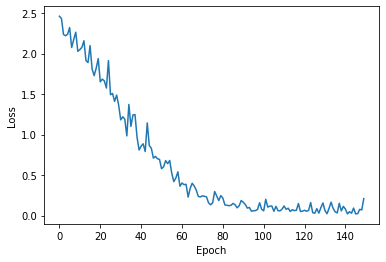

In [10]:
import matplotlib.pyplot as plt
plt.plot(model.epoch_loss_train)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'F1 Score')

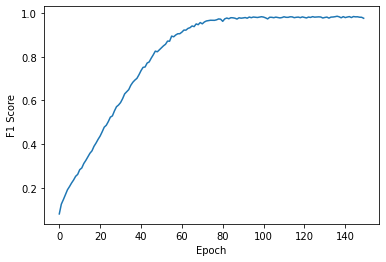

In [11]:
plt.plot(model.epoch_f1_train)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

Text(0, 0.5, 'Accuracy')

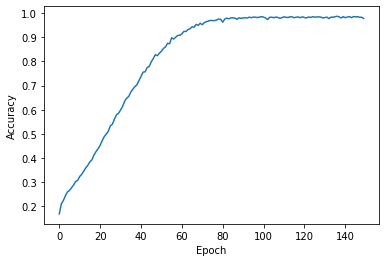

In [12]:
plt.plot(model.epoch_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

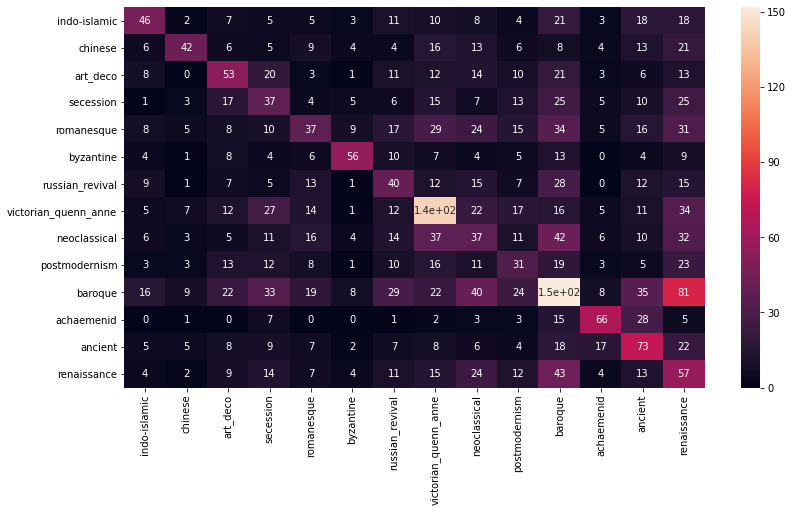

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
import pandas as pd
#Confiuson matrix
labels = list(dataset['labels_mapping'].keys())
y_pred = model.predict(images_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = labels_test
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (13,7))
sn.heatmap(df_cm, annot=True)

In [36]:
def show_image(image, correct, predicted):
    plt.imshow(image)
    plt.title(f'Correct: {correct} Predicted: {predicted}')
    plt.show()

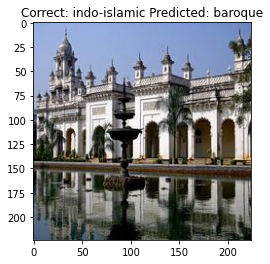

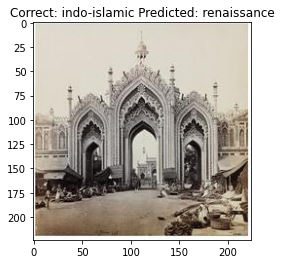

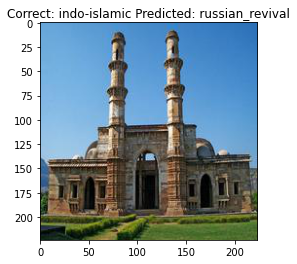

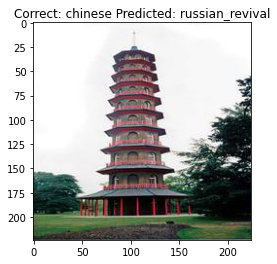

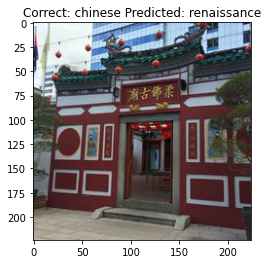

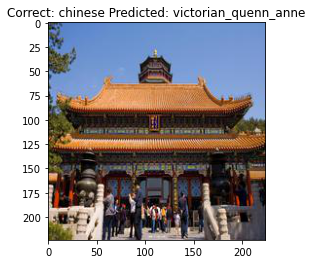

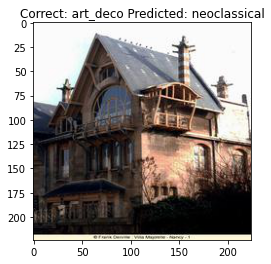

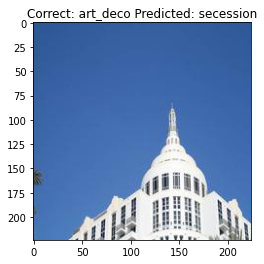

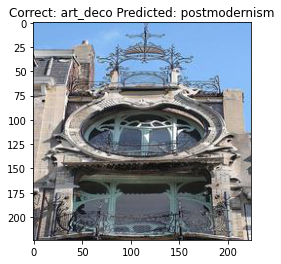

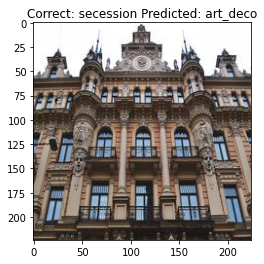

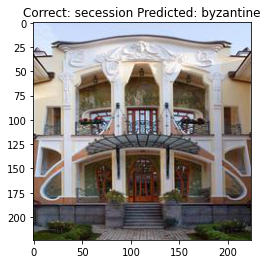

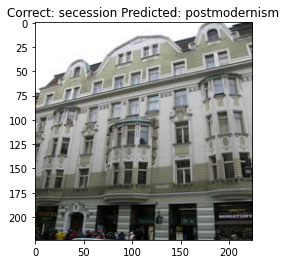

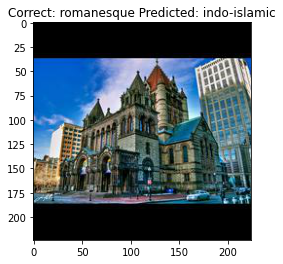

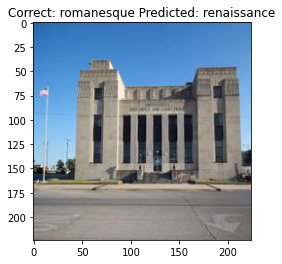

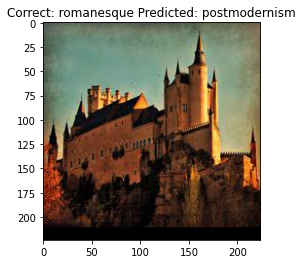

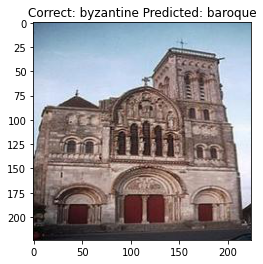

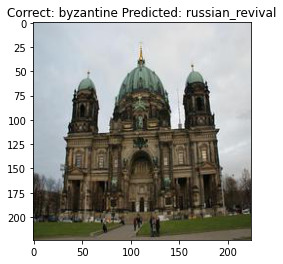

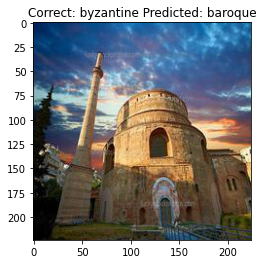

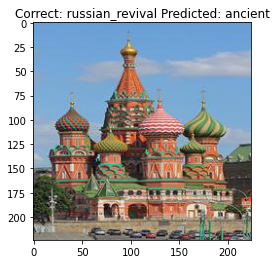

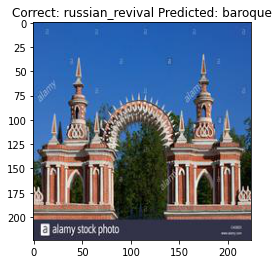

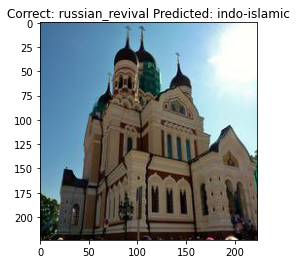

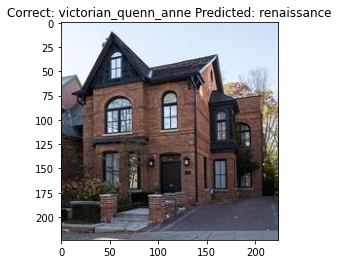

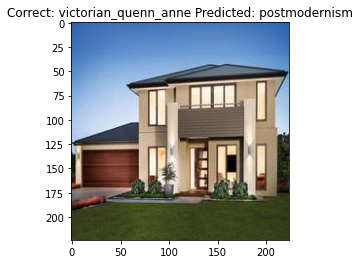

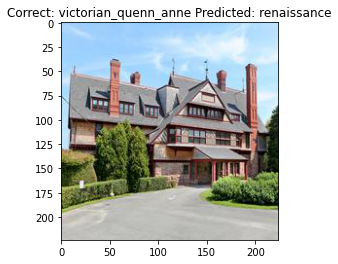

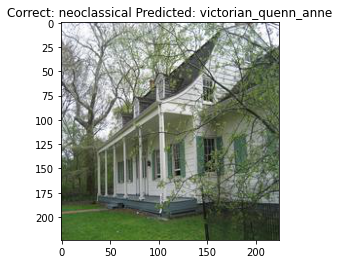

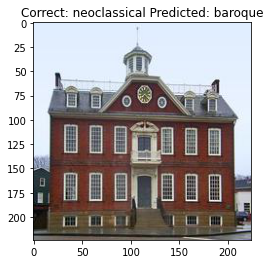

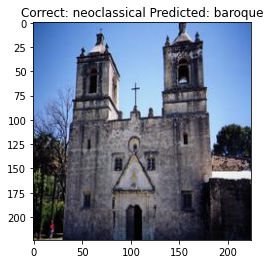

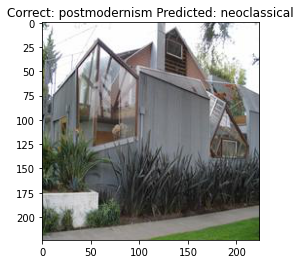

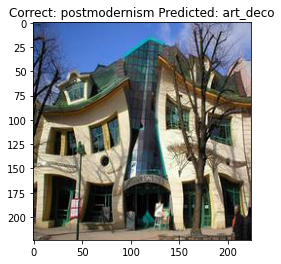

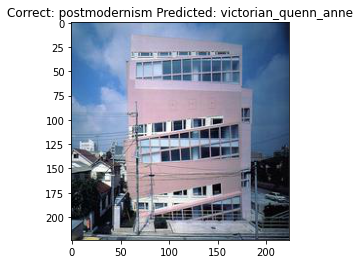

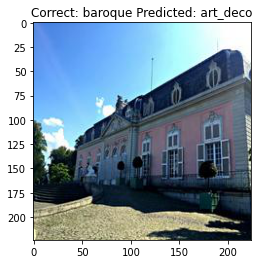

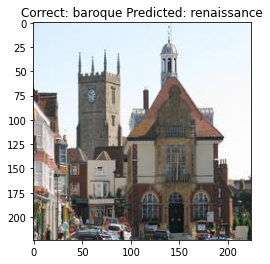

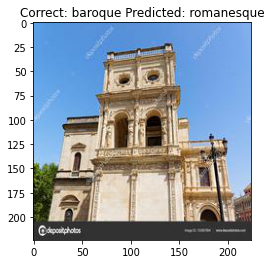

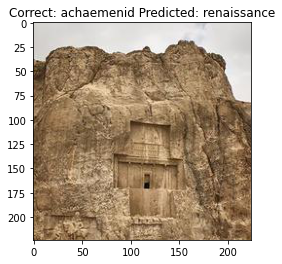

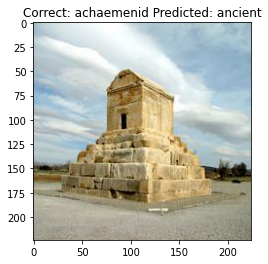

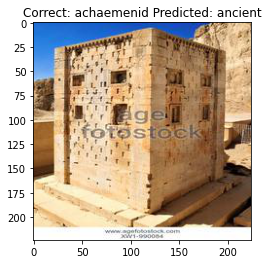

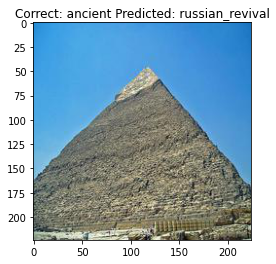

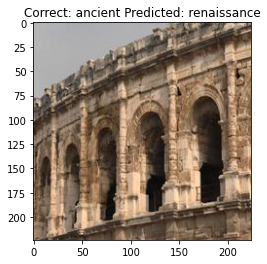

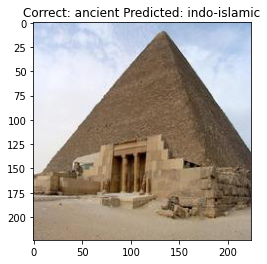

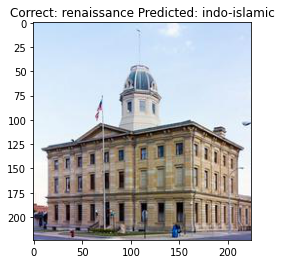

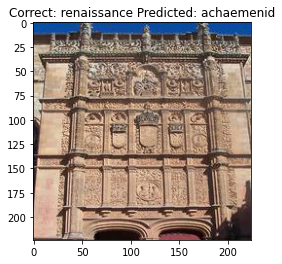

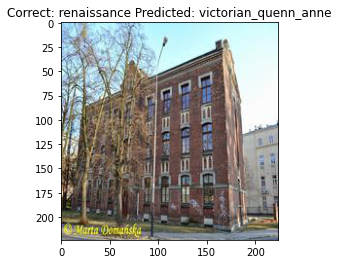

In [37]:
y_pred = model.predict(images_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = labels_test
labels = list(dataset['labels_mapping'].keys())
for c in range(14):
    count = 0
    for x, y_p, y_t in zip(images_test_before, y_pred, y_true):
        y_t = y_t.numpy()[0]
        if y_t == c:
            if (y_p != y_t) and count<3:
                count +=1
                show_image(x,labels[y_t],labels[y_p])
                

### Podsumowanie
#### Wyniki ostatecznego najlepszego modelu
- LOSS: 0.209
- F1: 0.30849629130141604

#### Macierz pomyłek i źle zaklasyfikowane obrazy
- Macierz pomyłek nie różni się znacząco od macierzy pomyłek z poprzedniego zadania
- Przykłady źle zakasyfikowanych obrazów są takie same jak w poprzednim zadaniu

#### Porównanie wyników z poprzednim zadaniem
- Dopasowanie hiperparametrów pozwoliło na poprawę F1 z ok. 20% na 25-30%